# IV - 0D computations H2

In [ ]:
#!cti2yaml h2_williams_12.cti

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt#
from matplotlib import *
import csv

scheme = 'BFER_methane'
Temp=       1200.0
T_str=     '1200'
n_points =  80500    #iterations    40000,50000,80000,300000
Dt = 2e-9            #2e-7

# Create a Cantera Solution object
gas = ct.Solution(scheme+'.yaml', 'CH4_BFER_mix')
gas.TPX = Temp, ct.one_atm, {'CH4': 1, 'O2': 2, 'N2': 7.52}
species_names = ['O2', 'H2O', 'CH4', 'CO', 'CO2', 'N2']
Ini_Temp=gas.T
# Get properties
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s
cp = gas.cp

species_names = gas.species_names
molar_masses = gas.molecular_weights/1000  # Molar masses in kg/mol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y
mol_frac = gas.X

print(gas())
print("-------------------------------------------------------")
print(f"Density (rho_0):\t {density:.4e} kg/m³")
print(f"Kine Visc (nu_0):\t {kinematic_viscosity:.4e} m²/s")
print(f"cp: \t\t\t{cp:.2f} ")
print(f"Therm Cond:(lambda)\t {thermal_conductivity:.4e} W/m/K\n\n")

for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]:.4f}")  # Print molar mass in SI units
    print(f"Mass Fraction: {mass_fractions[i]:.6f}")
    print(f"Mole Fraction: {mol_frac[i]:.6f}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]:.4e}")
    print("")



  CH4_BFER_mix:

       temperature   1200 K
          pressure   1.0133e+05 Pa
           density   0.28063 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6193e+05        2.3818e+07  J
   internal energy        5.0087e+05        1.3841e+07  J
           entropy            8914.2        2.4633e+05  J/K
    Gibbs function       -9.8351e+06       -2.7178e+08  J
 heat capacity c_p            1397.3             38611  J/K
 heat capacity c_v            1096.4             30296  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.747
               CH4          0.055187          0.095057           -35.961
                N2           0.72467           0.71483          

In [2]:
print("#name     Molar Mass")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {molar_masses[i]:.6f}")    
    
print("\n\n#    Initial mass fractions (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {mass_fractions[i]:.6f}", end="    " if i % 2 == 0 else "\n")

print("\n#    Initial diffusion coefficients (FLOW)")
for i in range(len(species_names)):
    print(f"{species_names[i]:<6} {diff_coeffs[i]:.4e}", end="    " if i % 2 == 0 else "\n")


#name     Molar Mass
O2     0.031998
H2O    0.018015
CH4    0.016043
CO     0.028010
CO2    0.044009
N2     0.028014


#    Initial mass fractions (FLOW)
O2     0.220141    H2O    0.000000
CH4    0.055187    CO     0.000000
CO2    0.000000    N2     0.724672

#    Initial diffusion coefficients (FLOW)
O2     2.1490e-04    H2O    2.8802e-04
CH4    2.5218e-04    CO     2.1977e-04
CO2    1.7877e-04    N2     2.1919e-04


In [3]:
gas.n_species
gas.n_reactions
#gas.species_names


2

In [4]:
# Reactor and environment
r = ct.IdealGasReactor(gas)             ##r = ct.Reactor(gas)
env = ct.Reservoir(gas)                 ##sim = ct.ReactorNet([r])

# Wall
w = ct.Wall(r, env)
w.expansion_rate_coeff = 1.0e6  # set expansion parameter. dV/dt = KA(P_1 - P_2)
w.area = 1.0

# Prepare the simulation with a ReactorNet object
sim = ct.ReactorNet([r])
time = 0
HR = []
temperature = []
mfrac = []
auto_ignitions = []
times = np.zeros(n_points)
data = np.zeros((n_points, len(species_names) + 3))  # +1 for temperature
header = 'Iteration,Time (s),Temperature,' + ','.join(species_names)

#print(('%10s %10s %10s %14s' % ('t [s]', 'T [K]', 'vol [m3]', 'u [J/kg]')))
for n in range(n_points):
    time += Dt
    sim.advance(time)
    times[n] = time  # time in s
    data[n, 0] = n + 1  # iteration number
    data[n, 1] = time  # time in s
    data[n, 2] = r.T  # set the temperature in the third column
    data[n, 3:] = r.thermo[species_names].X  # set the molar fractions in the remaining columns
    temperature.append(r.T)
    mfrac.append(r.thermo.Y)
    HR.append(- np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)) #Calculates the heat release rate using the net production rates of species and their partial molar enthalpies.
  
data_with_iteration = np.column_stack((data[:, :2], data[:, 2:]))   
np.savetxt('Results/CANTERA_'+scheme+'_species_molar_fractions'+T_str+'.csv', data_with_iteration, delimiter=',', header=header, comments='')

In [5]:
gas()


  CH4_BFER_mix:

       temperature   1839.7 K
          pressure   1.0133e+05 Pa
           density   0.18285 kg/m^3
  mean mol. weight   27.603 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6194e+05        2.3792e+07  J
   internal energy         3.078e+05        8.4963e+06  J
           entropy              9595        2.6485e+05  J/K
    Gibbs function        -1.679e+07       -4.6345e+08  J
 heat capacity c_p            1502.4             41471  J/K
 heat capacity c_v            1201.2             33156  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.14565           0.12565           -30.545
               H2O          0.042652          0.065353           -45.647
               CH4          0.036195          0.062276        

In [6]:
auto_ignition = times[HR.index(max(HR))] #Finds the ignition time (time of maximum heat release rate) by locating the index in the HR list where the maximum value occurs and then finding the corresponding time from the time list
print('For T = ' + str(Ini_Temp) + ', Autoignition time = ' + str(auto_ignition) + ' s')
# Posterity
FinalTemp = temperature[n_points - 1]
auto_ignitions.append(auto_ignition)

For T = 1200.0, Autoignition time = 0.00016100000000018807 s


In [7]:
gas()


  CH4_BFER_mix:

       temperature   1839.7 K
          pressure   1.0133e+05 Pa
           density   0.18285 kg/m^3
  mean mol. weight   27.603 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        8.6194e+05        2.3792e+07  J
   internal energy         3.078e+05        8.4963e+06  J
           entropy              9595        2.6485e+05  J/K
    Gibbs function        -1.679e+07       -4.6345e+08  J
 heat capacity c_p            1502.4             41471  J/K
 heat capacity c_v            1201.2             33156  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.14565           0.12565           -30.545
               H2O          0.042652          0.065353           -45.647
               CH4          0.036195          0.062276        

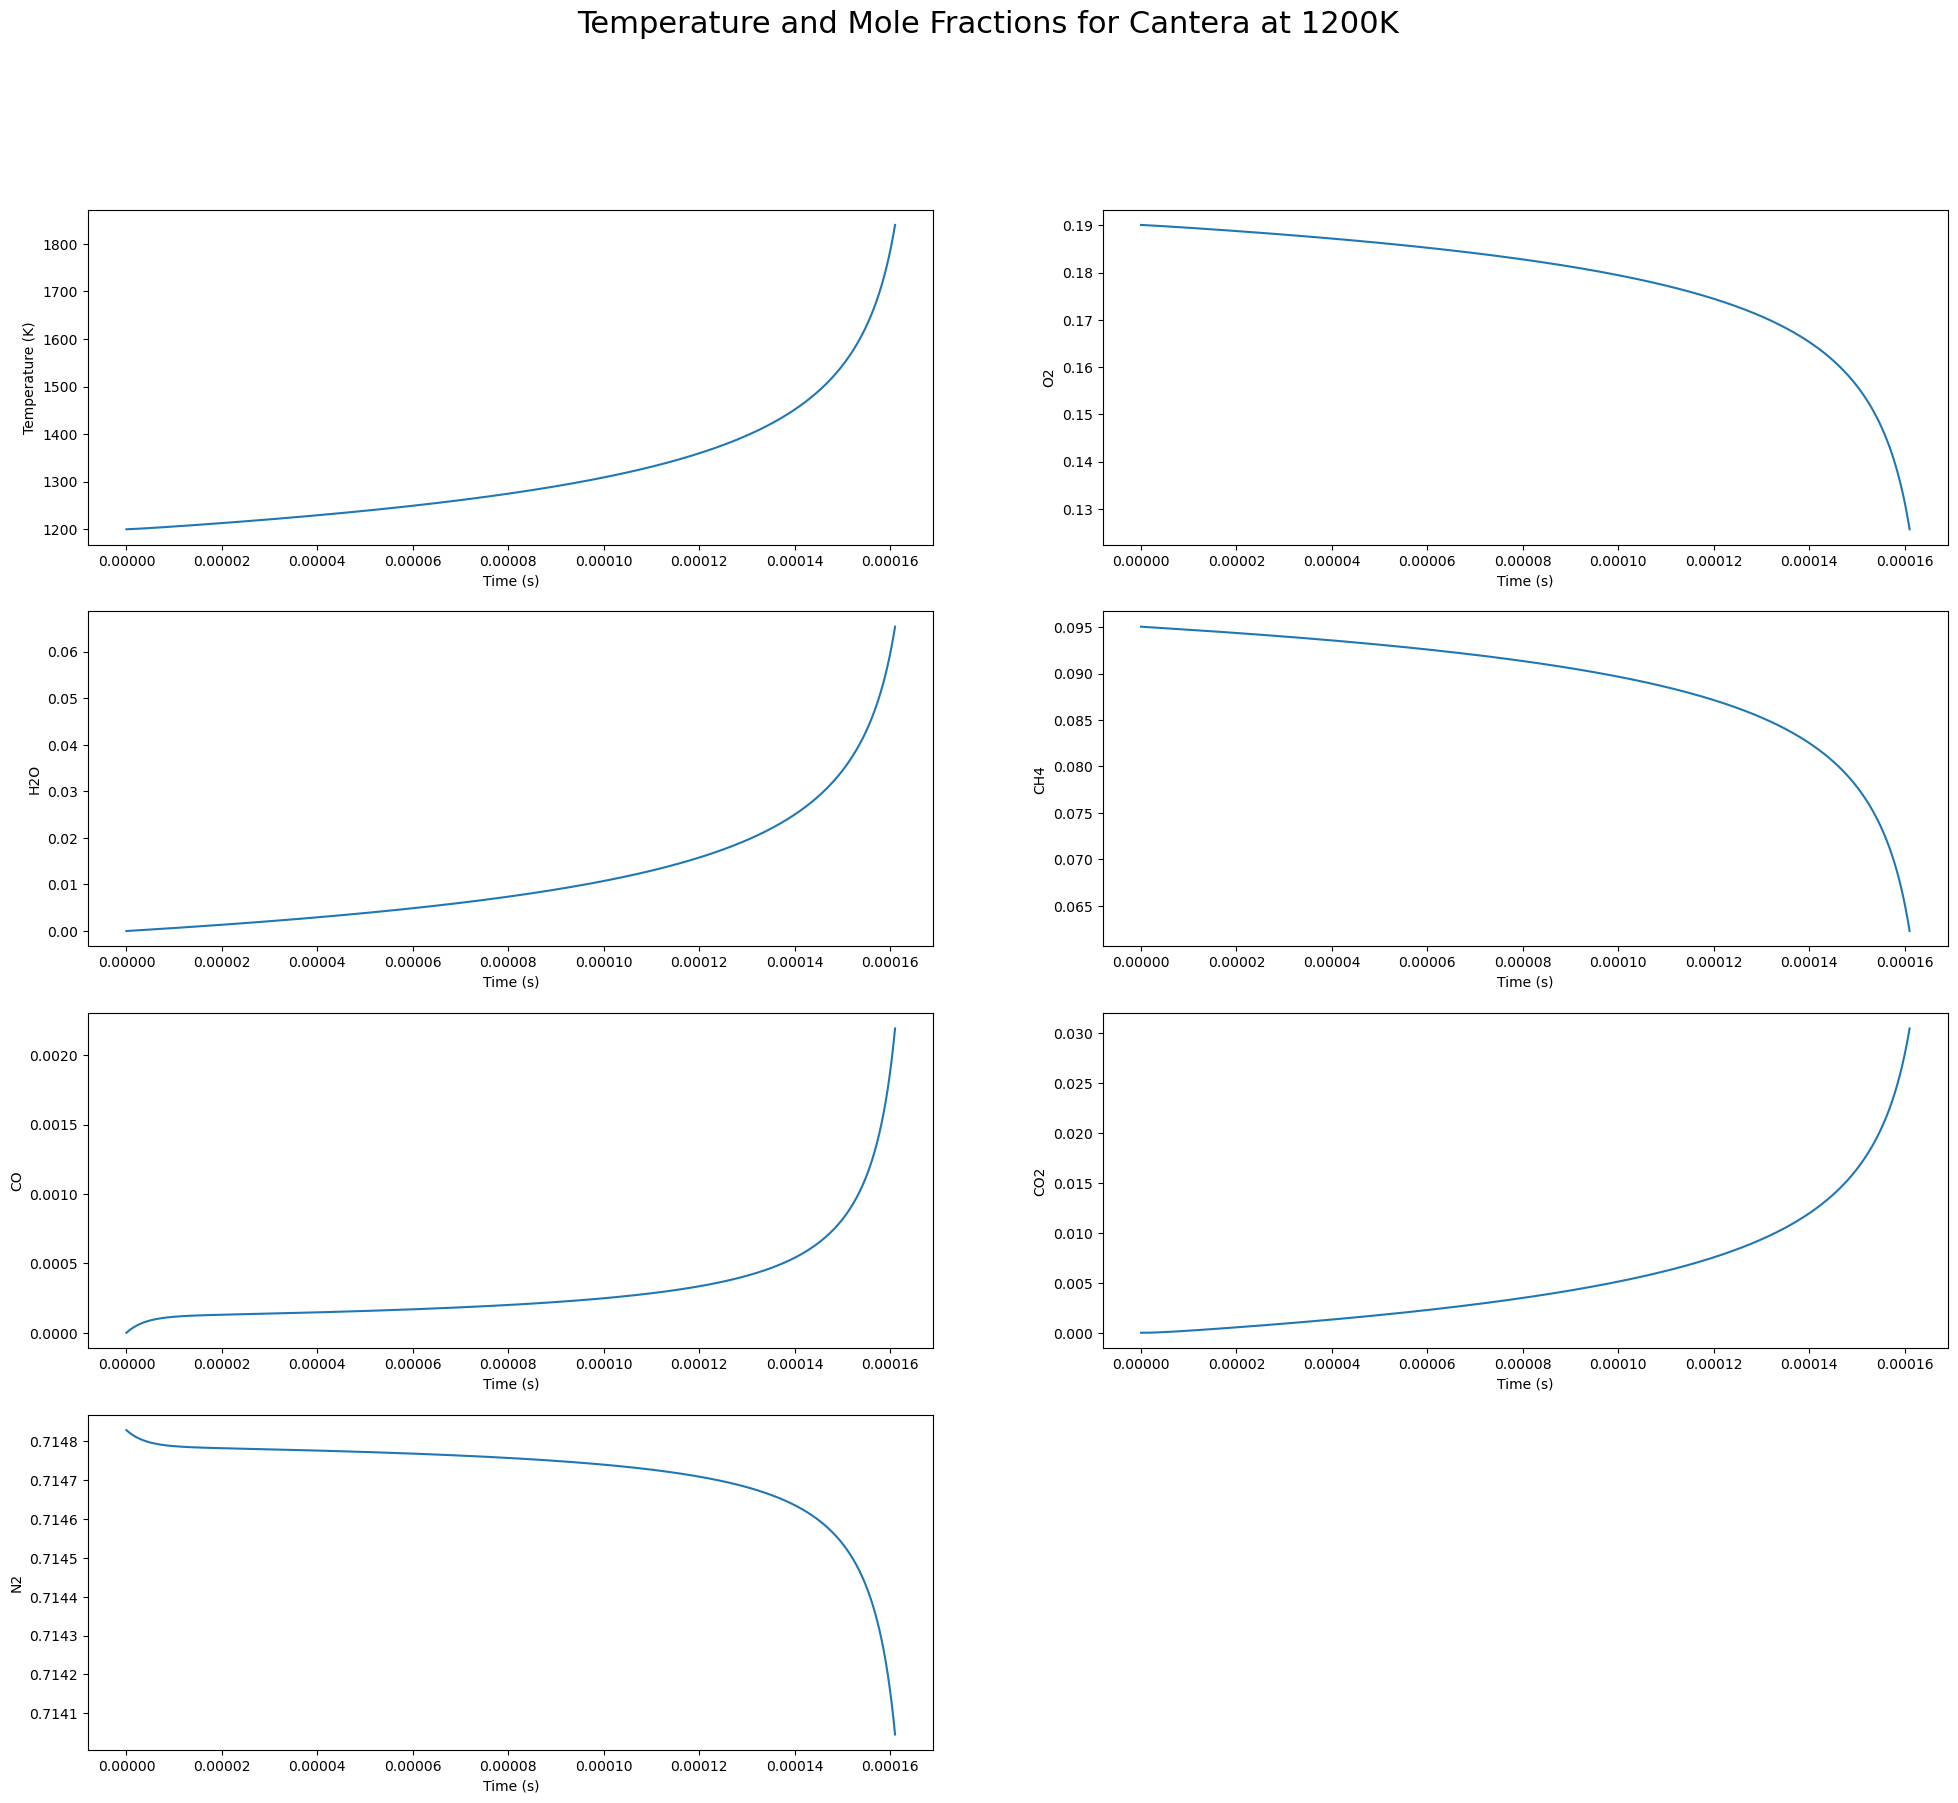

In [8]:
# Define your list of species
species_to_plot = ['Temperature (K)']+species_names

# Create a subplot grid dynamically based on the number of species
num_species = len(species_to_plot)
num_rows = int(np.ceil(num_species / 2))
num_cols = min(2, num_species)

# Set the figure size
plt.figure(figsize=(24, 20))

# Loop through each species and create a subplot
for i, species in enumerate(species_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(times, data[:, i + 2])
    plt.xlabel('Time (s)')
    plt.ylabel(species)
    

# Adjust subplot layout
#plt.tight_layout()
plt.suptitle('Temperature and Mole Fractions for Cantera at '+T_str+'K', fontsize=22)
plt.savefig(f'Results/0D-Cantera_'+scheme+'_{Temp}.png', dpi=300)
# Show the plot
plt.show()